In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl;
import cmocean.cm as cmo
import numpy as np
import gsw
import xgcm 
import xarray as xr
from xmitgcm import open_mdsdataset
import MITgcmutils.mnc as mnc
import matplotlib.cm as cm

In [2]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds



In [55]:
dss = open_mncdataset('run_bump_baro_stepfct/state', 2, 3, 0)
dsg = open_mncdataset('run_bump_baro_stepfct/grid', 2, 3, None)
ds=xr.merge((dss,dsg))
ds=ds.isel(Zp1=slice(0,-1))
ds=ds.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
ds = xgcm.generate_grid_ds(ds, {'X':'X', 'Y':'Y', 'Z':'Z'})
ds['drU']=ds.U.isel(T=0)*0+ds.drF.isel(X=30,Y=20)
ds['drV']=ds.V.isel(T=0)*0+ds.drF.isel(X=30,Y=20)
metrics = {
    ('X',): ['dxC', 'dxG', 'dxV'], # X distances
    ('Y',): ['dyC', 'dyG', 'dyU'], # Y distances
    ('Z',): ['drC', 'drF', 'drU', 'drV'], # Z distances
    }
grid = xgcm.Grid(ds, periodic=False,metrics=metrics)
ds.coords['day']=ds.T/(24*3600)
ds

<xarray.Dataset>
Dimensions:  (T: 731, X: 60, X_left: 60, Y: 40, Y_left: 40, Z: 100, Z_left: 100, Zl: 100, Zu: 100)
Coordinates: (12/13)
    Yp1      (Y_left) float64 0.0 2.5e+04 5e+04 ... 9.25e+05 9.5e+05 9.75e+05
    Xp1      (X_left) float64 0.0 2.5e+04 5e+04 ... 1.425e+06 1.45e+06 1.475e+06
  * T        (T) float64 0.0 8.64e+04 1.728e+05 ... 6.29e+07 6.299e+07 6.307e+07
  * Y        (Y) float64 1.25e+04 3.75e+04 6.25e+04 ... 9.625e+05 9.875e+05
  * Z        (Z) float64 -20.0 -60.0 -100.0 ... -3.9e+03 -3.94e+03 -3.98e+03
  * X        (X) float64 1.25e+04 3.75e+04 6.25e+04 ... 1.462e+06 1.488e+06
    ...       ...
    Zp1      (Z_left) float64 0.0 -40.0 -80.0 ... -3.88e+03 -3.92e+03 -3.96e+03
  * Zu       (Zu) float64 -40.0 -80.0 -120.0 ... -3.92e+03 -3.96e+03 -4e+03
  * X_left   (X_left) float64 0.0 2.5e+04 5e+04 ... 1.425e+06 1.45e+06 1.475e+06
  * Y_left   (Y_left) float64 0.0 2.5e+04 5e+04 ... 9.25e+05 9.5e+05 9.75e+05
  * Z_left   (Z_left) float64 0.0 -40.0 -80.0 ... -3.88e+03 -3.92e+03 -3.96e+03
    day      (T) float64 0.0 1.0 2.0 3.0 4.0 ... 726.0 727.0 728.0 729.0 730.0
Data variables: (12/39)
    iter     (Y, X, T) int32 dask.array<chunksize=(20, 20, 731), meta=np.ndarray>
    U        (T, Z, Y, X_left) float32 dask.array<chunksize=(731, 100, 20, 20), meta=np.ndarray>
    V        (T, Z, Y_left, X) float32 dask.array<chunksize=(731, 100, 20, 20), meta=np.ndarray>
    Temp     (T, Z, Y, X) float32 dask.array<chunksize=(731, 100, 20, 20), meta=np.ndarray>
    S        (T, Z, Y, X) float32 dask.array<chunksize=(731, 100, 20, 20), meta=np.ndarray>
    Eta      (T, Y, X) float32 dask.array<chunksize=(731, 20, 20), meta=np.ndarray>
    ...       ...
    Depth    (Y, X) float64 dask.array<chunksize=(20, 20), meta=np.ndarray>
    HFacC    (Z, Y, X) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    HFacW    (Z, Y, X_left) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    HFacS    (Z, Y_left, X) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    drU      (Z, Y, X_left) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    drV      (Z, Y_left, X) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>

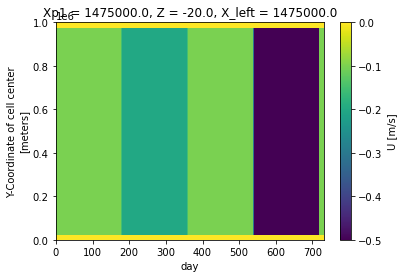

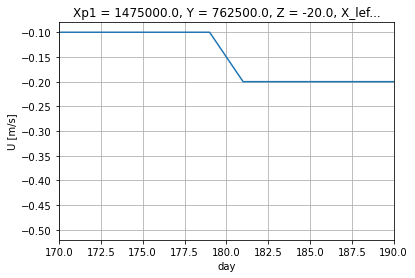

In [56]:
# check boundary conditions
ds.U.isel(Z=0,X_left=59).plot.pcolormesh(x="day",y="Y")
plt.xlabel('day')
plt.figure()
ds.U.isel(Z=0,X_left=59,Y=30).plot(x="day")
plt.xlim(170,190)
plt.grid()

Text(0.5, 1.0, 'day=170.0')

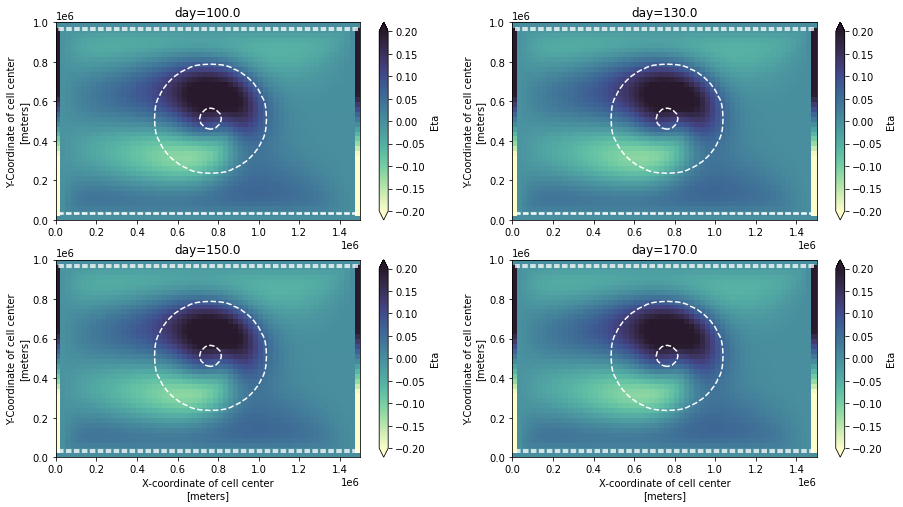

In [5]:
wmax=.2
wmin=-1*wmax
cmap2 = cm.get_cmap(cmo.deep,lut=15)

fig,axes=plt.subplots(2,2,figsize=(15,8))

ax=axes[0,0]
m=100
(ds.Eta.isel(T=m)-ds.Eta.isel(T=m,X=58)).plot.pcolormesh(cmap=cmap2,vmin=wmin,vmax=wmax,ax=ax)
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day={ds.day.isel(T=m).values}')
ax.set_xlabel('')

ax=axes[0,1]
m=130
(ds.Eta.isel(T=m)-ds.Eta.isel(T=m,X=58)).plot.pcolormesh(cmap=cmap2,vmin=wmin,vmax=wmax,ax=ax)
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day={ds.day.isel(T=m).values}')
ax.set_xlabel('')

ax=axes[1,0]
m=150
(ds.Eta.isel(T=m)-ds.Eta.isel(T=m,X=58)).plot.pcolormesh(cmap=cmap2,vmin=wmin,vmax=wmax,ax=ax)
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day={ds.day.isel(T=m).values}')


ax=axes[1,1]
m=170
(ds.Eta.isel(T=m)-ds.Eta.isel(T=m,X=58)).plot.pcolormesh(cmap=cmap2,vmin=wmin,vmax=wmax,ax=ax)
ds.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
ax.set_title(f'day={ds.day.isel(T=m).values}')


Text(0.5, 1.0, '100 vertical levels')

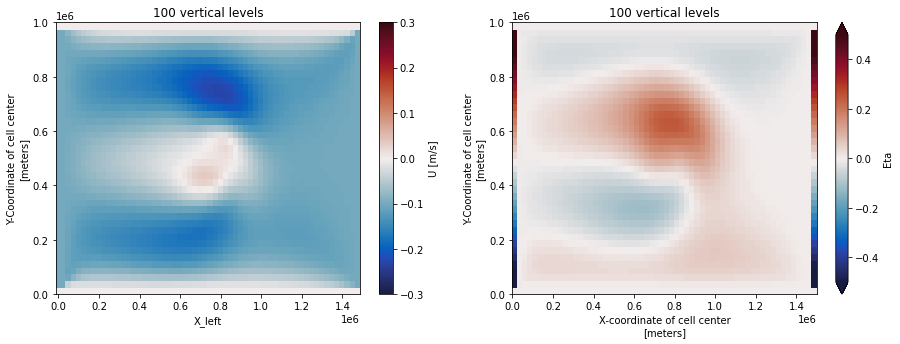

In [6]:
wmin=-0.3
wmax=0.3
cmap2 = cm.get_cmap(cmo.balance,lut=15)

fig,axes=plt.subplots(1,2,figsize=(15,5))


ds.U.isel(T=100,Z=10).plot.pcolormesh(cmap=cmap2,vmin=wmin,vmax=wmax,ax=axes[0])
axes[0].set_title('100 vertical levels')

(ds.Eta.isel(T=100)-ds.Eta.isel(T=100,X=58)).plot.pcolormesh(cmap=cmap2,vmin=-.5,vmax=.5,ax=axes[1])
axes[1].set_title('100 vertical levels')



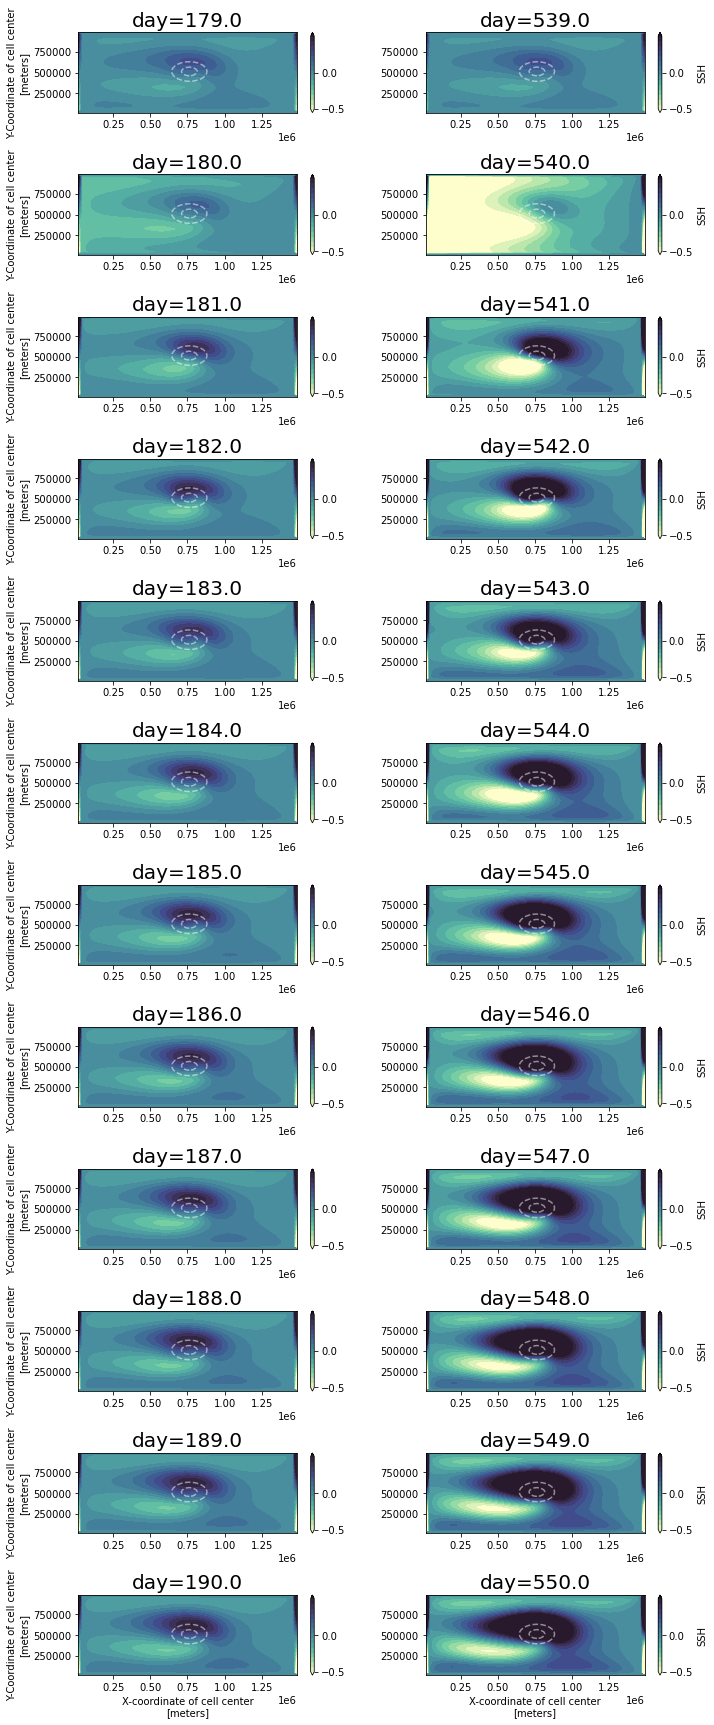

In [7]:
cmap2 = cmo.deep
wmax=.5
wmin=-1*wmax

normi = mpl.colors.Normalize(vmin=wmin, vmax=wmax) 

fig, axes = plt.subplots(12,2, figsize=(10,24),gridspec_kw={"width_ratios":[1,1]})
k1=179
k2=539
for i in range(0,len(axes[:,1])):
    (ds.Eta.isel(T=k1)-ds.Eta.isel(T=k1,X=58)).plot.contourf(vmin=wmin,vmax=wmax,levels=16,cmap=cmap2,ax=axes[i,0],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3500],ax=axes[i,0],linestyles='--',colors='w',alpha=0.5)
    axes[i,0].set_title(f'day={ds.day.isel(T=k1).values}',fontsize=20) 
    plt.tight_layout()
    (ds.Eta.isel(T=k2)-ds.Eta.isel(T=k2,X=58)).plot.contourf(vmin=wmin,vmax=wmax,levels=16,cmap=cmap2,ax=axes[i,1],cbar_kwargs={'label':'SSH','ticks':np.arange(wmin,wmax,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3500],ax=axes[i,1],linestyles='--',colors='w',alpha=0.5)
    axes[i,1].set_title(f'day={ds.day.isel(T=k2).values}',fontsize=20) 
    plt.tight_layout()
    k1=k1+1
    k2=k2+1
    axes[i,1].set_ylabel('')
    if i<(len(axes[:,1])-1):
        axes[i,1].set_xlabel('')
        axes[i,0].set_xlabel('')
        

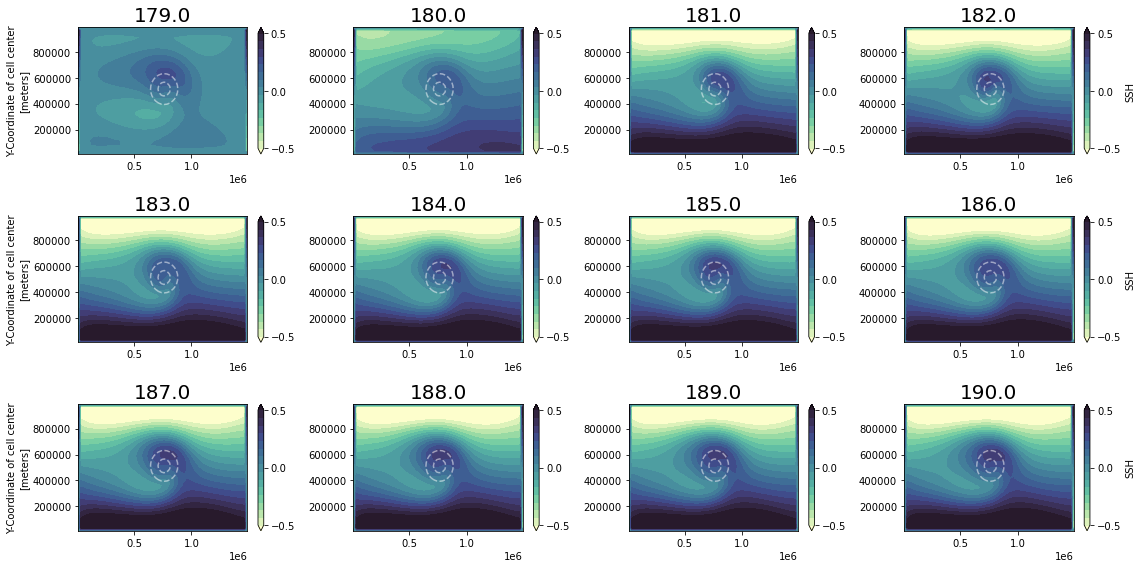

In [8]:
cmap2 = cmo.deep
wmax=.5
wmin=-1*wmax

normi = mpl.colors.Normalize(vmin=wmin, vmax=wmax) 

fig, axes = plt.subplots(3,4, figsize=(16,8),gridspec_kw={"width_ratios":[1,1,1,1]})
k1=179
k2=180
k3=181
k4=182
for i in range(0,len(axes[:,1])):
    (ds.Eta.isel(T=k1)-ds.Eta.isel(T=179,X=58)).plot.contourf(vmin=wmin,vmax=wmax,levels=16,cmap=cmap2,ax=axes[i,0],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3500],ax=axes[i,0],linestyles='--',colors='w',alpha=0.5)
    axes[i,0].set_title(f'{ds.day.isel(T=k1).values}',fontsize=20) 
    plt.tight_layout()
    (ds.Eta.isel(T=k2)-ds.Eta.isel(T=179,X=58)).plot.contourf(vmin=wmin,vmax=wmax,levels=16,cmap=cmap2,ax=axes[i,1],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3500],ax=axes[i,1],linestyles='--',colors='w',alpha=0.5)
    axes[i,1].set_title(f'{ds.day.isel(T=k2).values}',fontsize=20) 
    (ds.Eta.isel(T=k3)-ds.Eta.isel(T=179,X=58)).plot.contourf(vmin=wmin,vmax=wmax,levels=16,cmap=cmap2,ax=axes[i,2],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3500],ax=axes[i,2],linestyles='--',colors='w',alpha=0.5)
    axes[i,2].set_title(f'{ds.day.isel(T=k3).values}',fontsize=20) 
    (ds.Eta.isel(T=k4)-ds.Eta.isel(T=179,X=58)).plot.contourf(vmin=wmin,vmax=wmax,levels=16,cmap=cmap2,ax=axes[i,3],cbar_kwargs={'label':'SSH','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3500],ax=axes[i,3],linestyles='--',colors='w',alpha=0.5)
    axes[i,3].set_title(f'{ds.day.isel(T=k4).values}',fontsize=20) 
    plt.tight_layout()
    k1=k1+4
    k2=k2+4
    k3=k3+4
    k4=k4+4
    axes[i,1].set_ylabel('')
    axes[i,2].set_ylabel('')
    axes[i,3].set_ylabel('')
    if i<(len(axes[:,1])):
        axes[i,1].set_xlabel('')
        axes[i,0].set_xlabel('')
        axes[i,2].set_xlabel('')
        axes[i,3].set_xlabel('')
        
    plt.tight_layout()
#plt.savefig('./stepfct_ssh.png',dpi=300)

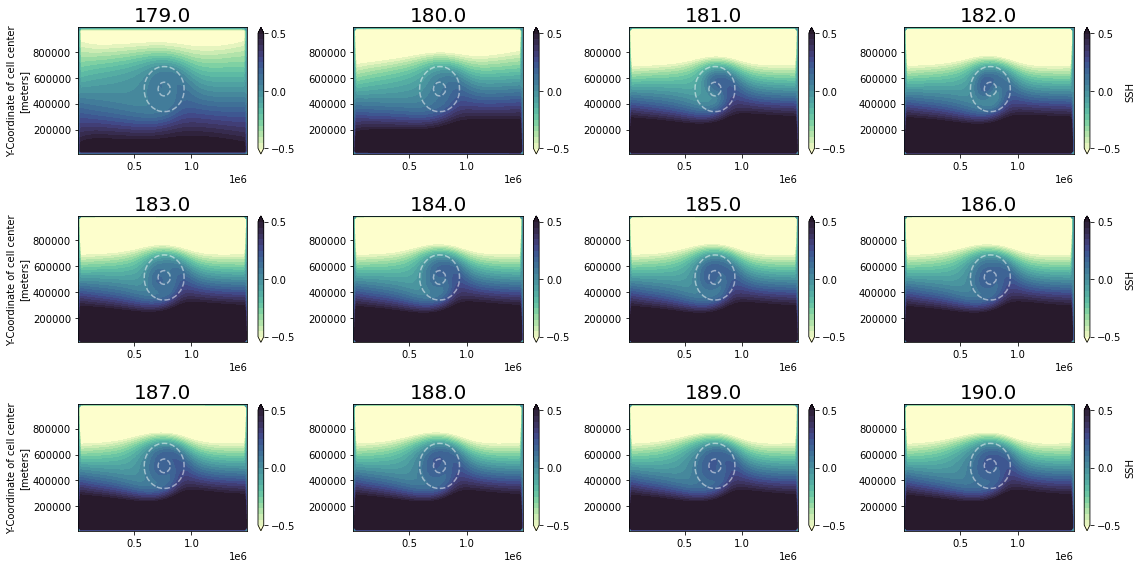

In [9]:
cmap2 = cmo.deep
wmax=.5
wmin=-1*wmax
lev=21
normi = mpl.colors.Normalize(vmin=wmin, vmax=wmax) 

fig, axes = plt.subplots(3,4, figsize=(16,8),gridspec_kw={"width_ratios":[1,1,1,1]})
k1=179
k2=180
k3=181
k4=182
for i in range(0,len(axes[:,1])):
    (ds.Eta.isel(T=k1)).plot.contourf(vmin=wmin,vmax=wmax,levels=lev,cmap=cmap2,ax=axes[i,0],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3900],ax=axes[i,0],linestyles='--',colors='w',alpha=0.5)
    axes[i,0].set_title(f'{ds.day.isel(T=k1).values}',fontsize=20) 
    plt.tight_layout()
    (ds.Eta.isel(T=k2)).plot.contourf(vmin=wmin,vmax=wmax,levels=lev,cmap=cmap2,ax=axes[i,1],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3900],ax=axes[i,1],linestyles='--',colors='w',alpha=0.5)
    axes[i,1].set_title(f'{ds.day.isel(T=k2).values}',fontsize=20) 
    (ds.Eta.isel(T=k3)).plot.contourf(vmin=wmin,vmax=wmax,levels=lev,cmap=cmap2,ax=axes[i,2],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3900],ax=axes[i,2],linestyles='--',colors='w',alpha=0.5)
    axes[i,2].set_title(f'{ds.day.isel(T=k3).values}',fontsize=20) 
    (ds.Eta.isel(T=k4)).plot.contourf(vmin=wmin,vmax=wmax,levels=lev,cmap=cmap2,ax=axes[i,3],cbar_kwargs={'label':'SSH','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3900],ax=axes[i,3],linestyles='--',colors='w',alpha=0.5)
    axes[i,3].set_title(f'{ds.day.isel(T=k4).values}',fontsize=20) 
    plt.tight_layout()
    k1=k1+4
    k2=k2+4
    k3=k3+4
    k4=k4+4
    axes[i,1].set_ylabel('')
    axes[i,2].set_ylabel('')
    axes[i,3].set_ylabel('')
    if i<(len(axes[:,1])):
        axes[i,1].set_xlabel('')
        axes[i,0].set_xlabel('')
        axes[i,2].set_xlabel('')
        axes[i,3].set_xlabel('')
        
    plt.tight_layout()
#plt.savefig('./stepfct_ssh.png',dpi=300)

(175.0, 200.0)

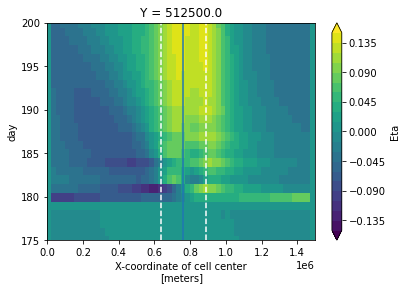

In [116]:
emin=-.15
emax=-1*emin
elev=21
(ds.Eta-ds.Eta.isel(T=179).values).isel(Y=20).plot.pcolormesh(y="day",vmin=emin,vmax=emax,levels=elev)
plt.vlines(ds.X.where(ds.Depth==2000).isel(Y=20),ymin=175,ymax=200)
plt.vlines(ds.X.where(ds.Depth==3580.77734375).isel(Y=20),ymin=175,ymax=200,colors='w',ls='--')
plt.ylim(175,200)

In [134]:
# compute wave speed
# distance at approx 3500 isobath
d=ds.X.where(ds.Depth.isel(Y=20)==3580.77734375,drop=True).values
r=(d[1]-d[0])/2
print('radius:',r)
#compute half of the circumference
cirfer=np.pi*r
# using the hovmöller diagramm above. the signal (neg value) at 181 day on the left travels to the right within a day
cwave=cirfer/86400
print('wave speed',cwave)
print('c=sqrt(gH)',np.sqrt(g*H0))

radius: 125000.0
wave speed 4.545128260401899
c=sqrt(gH) 140.07141035914503


In [127]:
d=ds.X.where(ds.Depth.isel(Y=20)==3580.77734375,drop=True).values
r=(d[1]-d[0])/2

In [133]:
np.sqrt(10*2000)

141.4213562373095

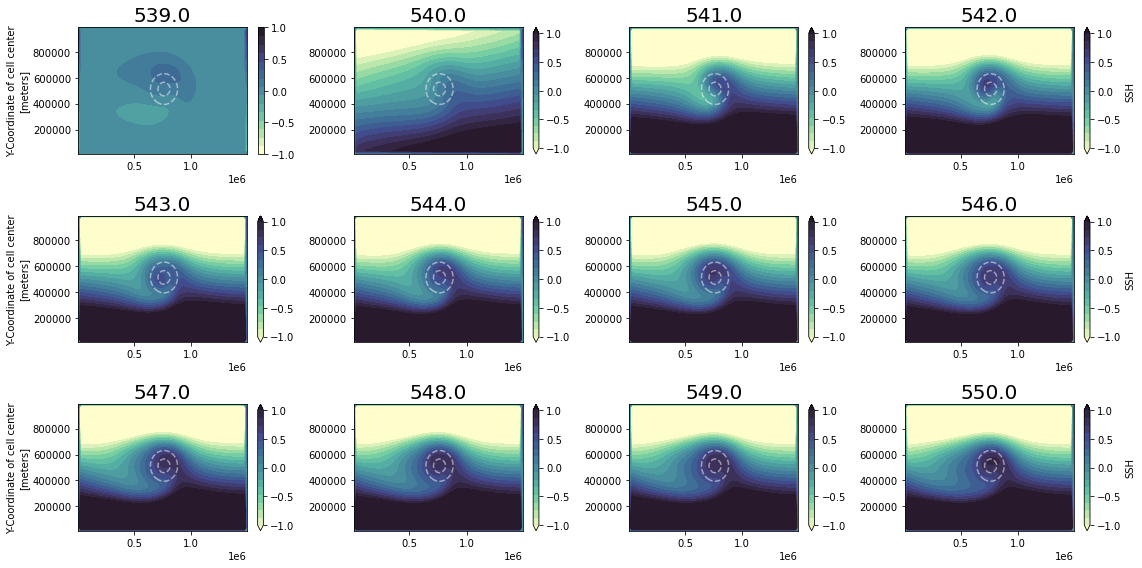

In [48]:
cmap2 = cmo.deep
wmax=1
wmin=-1*wmax

normi = mpl.colors.Normalize(vmin=wmin, vmax=wmax) 

fig, axes = plt.subplots(3,4, figsize=(16,8),gridspec_kw={"width_ratios":[1,1,1,1]})
k1=539
k2=540
k3=541
k4=542
for i in range(0,len(axes[:,1])):
    (ds.Eta.isel(T=k1)-ds.Eta.isel(T=179,X=58)).plot.contourf(vmin=wmin,vmax=wmax,levels=16,cmap=cmap2,ax=axes[i,0],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3500],ax=axes[i,0],linestyles='--',colors='w',alpha=0.5)
    axes[i,0].set_title(f'{ds.day.isel(T=k1).values}',fontsize=20) 
    plt.tight_layout()
    (ds.Eta.isel(T=k2)-ds.Eta.isel(T=179,X=58)).plot.contourf(vmin=wmin,vmax=wmax,levels=16,cmap=cmap2,ax=axes[i,1],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3500],ax=axes[i,1],linestyles='--',colors='w',alpha=0.5)
    axes[i,1].set_title(f'{ds.day.isel(T=k2).values}',fontsize=20) 
    (ds.Eta.isel(T=k3)-ds.Eta.isel(T=179,X=58)).plot.contourf(vmin=wmin,vmax=wmax,levels=16,cmap=cmap2,ax=axes[i,2],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3500],ax=axes[i,2],linestyles='--',colors='w',alpha=0.5)
    axes[i,2].set_title(f'{ds.day.isel(T=k3).values}',fontsize=20) 
    (ds.Eta.isel(T=k4)-ds.Eta.isel(T=179,X=58)).plot.contourf(vmin=wmin,vmax=wmax,levels=16,cmap=cmap2,ax=axes[i,3],cbar_kwargs={'label':'SSH','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3500],ax=axes[i,3],linestyles='--',colors='w',alpha=0.5)
    axes[i,3].set_title(f'{ds.day.isel(T=k4).values}',fontsize=20) 
    plt.tight_layout()
    k1=k1+4
    k2=k2+4
    k3=k3+4
    k4=k4+4
    axes[i,1].set_ylabel('')
    axes[i,2].set_ylabel('')
    axes[i,3].set_ylabel('')
    if i<(len(axes[:,1])):
        axes[i,1].set_xlabel('')
        axes[i,0].set_xlabel('')
        axes[i,2].set_xlabel('')
        axes[i,3].set_xlabel('')
        
    plt.tight_layout()
#plt.savefig('./stepfct_ssh.png',dpi=300)

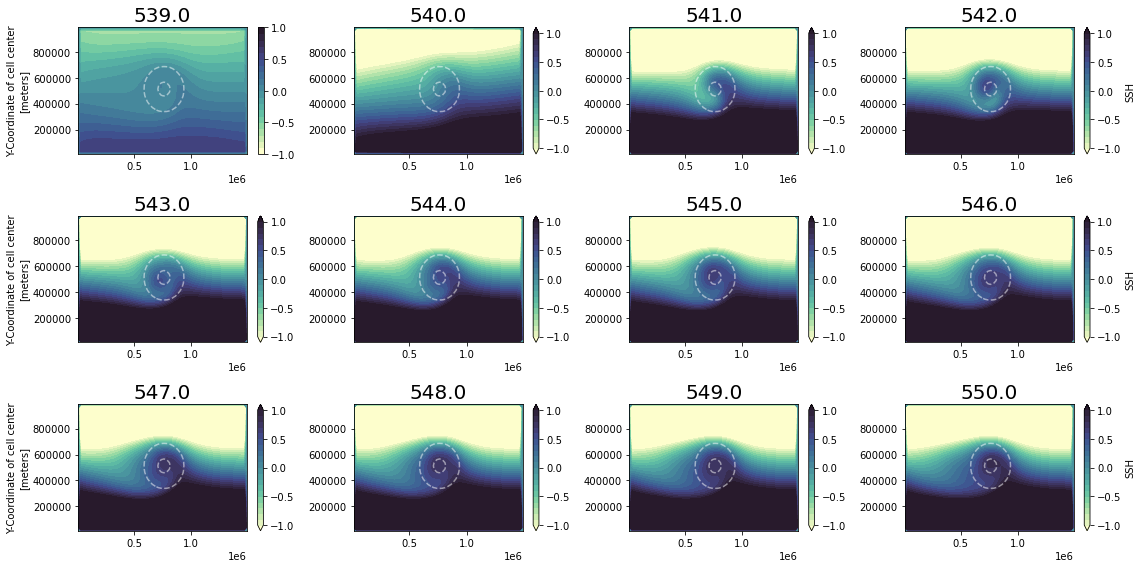

In [45]:
cmap2 = cmo.deep
wmax=1
wmin=-1*wmax
lev=21
normi = mpl.colors.Normalize(vmin=wmin, vmax=wmax) 

fig, axes = plt.subplots(3,4, figsize=(16,8),gridspec_kw={"width_ratios":[1,1,1,1]})
k1=539
k2=540
k3=541
k4=542
for i in range(0,len(axes[:,1])):
    (ds.Eta.isel(T=k1)).plot.contourf(vmin=wmin,vmax=wmax,levels=lev,cmap=cmap2,ax=axes[i,0],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3900],ax=axes[i,0],linestyles='--',colors='w',alpha=0.5)
    axes[i,0].set_title(f'{ds.day.isel(T=k1).values}',fontsize=20) 
    plt.tight_layout()
    (ds.Eta.isel(T=k2)).plot.contourf(vmin=wmin,vmax=wmax,levels=lev,cmap=cmap2,ax=axes[i,1],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3900],ax=axes[i,1],linestyles='--',colors='w',alpha=0.5)
    axes[i,1].set_title(f'{ds.day.isel(T=k2).values}',fontsize=20) 
    (ds.Eta.isel(T=k3)).plot.contourf(vmin=wmin,vmax=wmax,levels=lev,cmap=cmap2,ax=axes[i,2],cbar_kwargs={'label':'','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3900],ax=axes[i,2],linestyles='--',colors='w',alpha=0.5)
    axes[i,2].set_title(f'{ds.day.isel(T=k3).values}',fontsize=20) 
    (ds.Eta.isel(T=k4)).plot.contourf(vmin=wmin,vmax=wmax,levels=lev,cmap=cmap2,ax=axes[i,3],cbar_kwargs={'label':'SSH','ticks':np.arange(wmin,wmax+.5,.5)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3900],ax=axes[i,3],linestyles='--',colors='w',alpha=0.5)
    axes[i,3].set_title(f'{ds.day.isel(T=k4).values}',fontsize=20) 
    plt.tight_layout()
    k1=k1+4
    k2=k2+4
    k3=k3+4
    k4=k4+4
    axes[i,1].set_ylabel('')
    axes[i,2].set_ylabel('')
    axes[i,3].set_ylabel('')
    if i<(len(axes[:,1])):
        axes[i,1].set_xlabel('')
        axes[i,0].set_xlabel('')
        axes[i,2].set_xlabel('')
        axes[i,3].set_xlabel('')
        
    plt.tight_layout()
#plt.savefig('./stepfct_ssh.png',dpi=300)

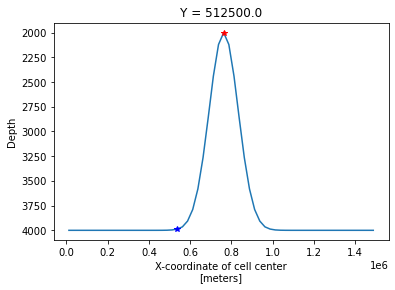

In [10]:
ds.Depth.isel(Y=20).plot()
plt.plot(ds.X.isel(X=30),ds.Depth.isel(Y=20,X=30),'r*')
plt.plot(ds.X.isel(X=21),ds.Depth.isel(Y=20,X=21),'b*')
plt.gca().invert_yaxis()

In [43]:
H0=ds.Depth.isel(Y=20,X=30).values
#compute slope of the bump
a=ds.X.isel(X=30)-ds.X.isel(X=21)
b=ds.Depth.isel(Y=20,X=21)-H0
# compute coriolis parameter for the domain
f=ds.fCori.mean(dim={'X','Y'}).values #1/s
print('Coriolis parameter',f)
# compute angle at blue mark
alpha=np.rad2deg(np.arctan(b/a)).values
print('slope',alpha)
#compute the maximum possible wave speed
g=9.81 #m/s2
c_max=alpha*g/f #m/s
print('maximum possible wave speed along the isobath',np.round(c_max,2), 'm/s')
# deformation radius
R=(np.sqrt(g*H0))/np.abs(f) #m
print('deformation radius',np.round(R,0),'m')
# compute the maximum frequency
omega_max=(np.abs(alpha)*g)/(2*np.abs(f)*R) #1/s
print('maximum frequency',omega_max)


Coriolis parameter -0.00012563499999999997
slope 0.5060589622542656
maximum possible wave speed along the isobath -39514.77 m/s
deformation radius 1114908.0 m
maximum frequency 0.01772109814196008


In [180]:
ds['speed']=np.sqrt((grid.interp(ds.V,'Y',boundary="extend"))**2+(grid.interp(ds.U,'X',boundary="extend"))**2)


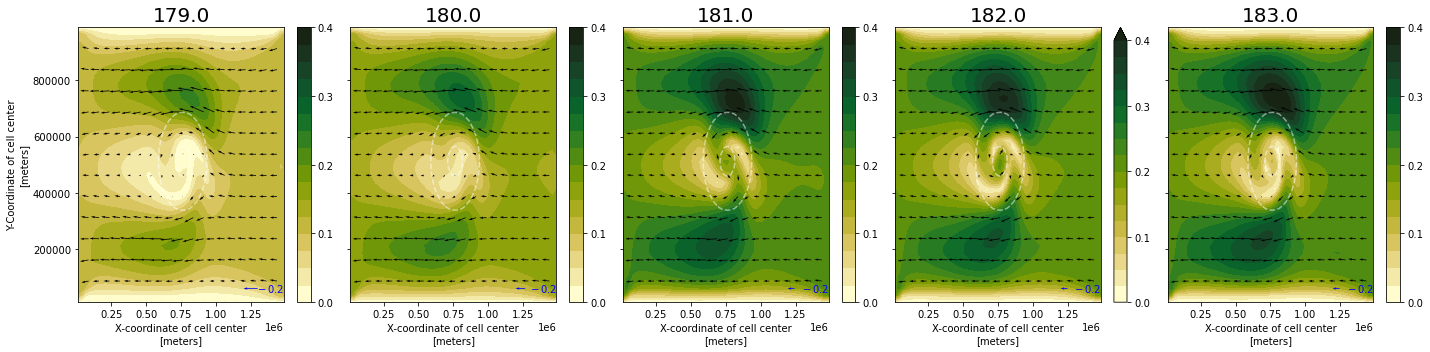

In [179]:
cmap2=cmo.speed
smin=0
smax=0.4
lev=17
arr=3
fig, axes = plt.subplots(1,5, figsize=(20,5),gridspec_kw={"width_ratios":[1,1,1,1,1]})

k1=179

for i in range(0,len(axes)):
    ds.speed.isel(T=k1,Z=0).plot.contourf(vmin=smin,vmax=smax,levels=lev,cmap=cmap2,ax=axes[i],cbar_kwargs={'label':'','ticks':np.arange(smin,smax+.1,.1)})
    ds.Depth.isel(X=slice(2,-2),Y=slice(2,-2)).plot.contour(levels=[2500,3900],ax=axes[i],linestyles='--',colors='w',alpha=0.5)
    q=axes[i].quiver(ds.X[0:-1:arr],ds.Y[0:-1:arr],grid.interp(ds.isel(T=k1,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(ds.isel(T=k1,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
    axes[i].quiverkey(q,0.8,0.05,-.2,label='$-\,0.2$',color='b',labelpos='E',labelcolor='b',labelsep=0.2)
    axes[i].set_title(f'{ds.day.isel(T=k1).values}',fontsize=20) 

    if i>0:
        axes[i].set_ylabel('')
        axes[i].set_yticklabels('')
    
    k1=k1+1
    plt.tight_layout()
